In [1]:
import numpy as np

from synthacc.spectral import plot_fass

In [2]:
frequencies = np.logspace(-2, 2, 500) ## Number of frequencies must be large enough for RVT

In [3]:
from synthacc.source.moment import mw_to_m0
from synthacc.stochastic import OmegaSquareSourceModel


m0 = mw_to_m0(7.5)
sd = 250 * 10**5
rp = 0.55
pf = 1 / np.sqrt(2)
fsf = 2
rho = 2800
vel = 3700

source_model = OmegaSquareSourceModel(m0, sd, rp, pf, fsf, rho, vel)

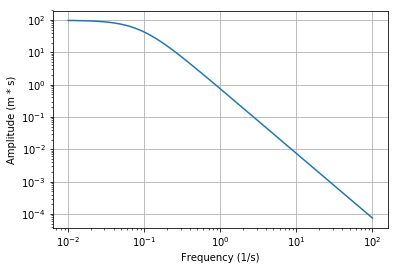

In [4]:
fas = source_model(frequencies)
fas.plot()

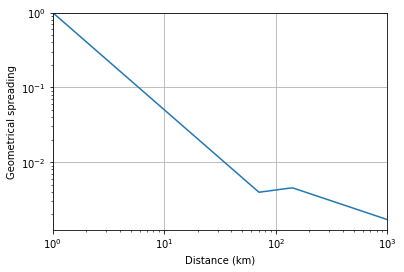

In [5]:
from synthacc.stochastic import GeometricalSpreadingModel


gs_segments = [
    (1, -1.3),
    (70, 0.2),
    (140, -0.5)
    ]

gs_model = GeometricalSpreadingModel(gs_segments)
gs_model.plot(np.logspace(0, 3, 100), max_distance=1000)

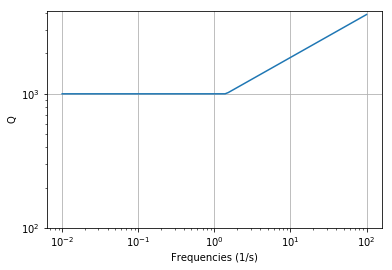

In [6]:
from synthacc.stochastic import QModel


qr1 = 1000
ft1 = 0.2
fr1 = 0.02
s1 = 0.0
qr2 = 1272
ft2 = 1.4242
fr2 = 3.02
s2 = 0.32

q_model = QModel(fr1, qr1, s1, ft1, ft2, fr2, qr2, s2)
q_model.plot(np.logspace(-2, 2, 100), min_q=10**2)

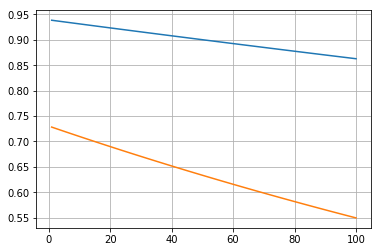

In [7]:
from synthacc.stochastic import AttenuationModel


c_q = 3.7 # km/s
kappa = 0.02

attenuation_model = AttenuationModel(q_model, c_q, kappa)
attenuation_model.plot(np.linspace(1, 100, 100), frequencies=[1, 5])

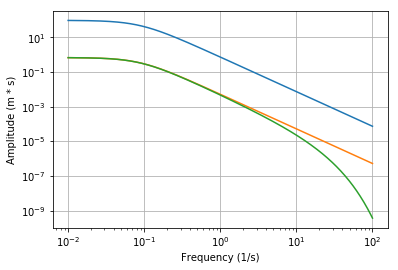

In [8]:
distance = 45 ## km

fas1 = source_model(frequencies, gmt='dis')
fas2 = source_model(frequencies, gmt='dis') * gs_model(distance)
fas3 = source_model(frequencies, gmt='dis') * gs_model(distance) * attenuation_model(distance, frequencies)

plot_fass([fas1, fas2, fas3])

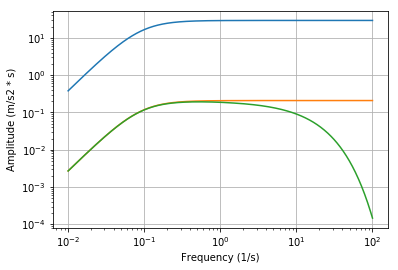

In [9]:
fas1 = source_model(frequencies, gmt='acc')
fas2 = source_model(frequencies, gmt='acc') * gs_model(distance)
fas3 = source_model(frequencies, gmt='acc') * gs_model(distance) * attenuation_model(distance, frequencies)

plot_fass([fas1, fas2, fas3])

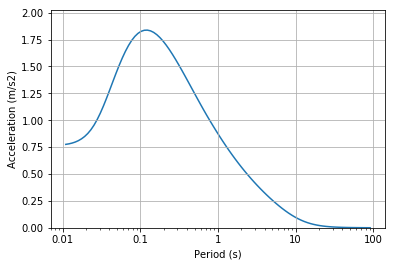

In [10]:
## Get response spectrum with random vibration theory

from synthacc.response import RVTCalculator


periods = np.logspace(-2, 2, 100)
calc = RVTCalculator()

rvt_rs = calc.get_response_spectrum(fas3, periods, duration=10, damping=0.05)

rvt_rs.plot()

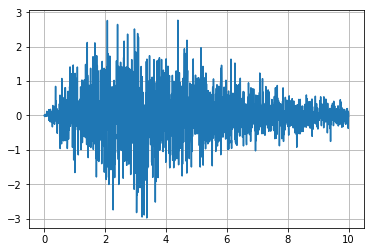

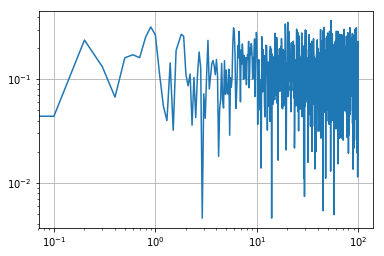

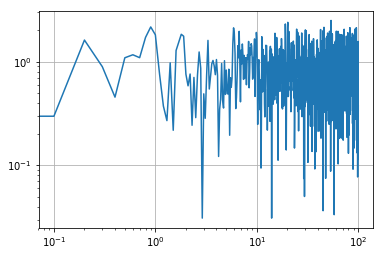

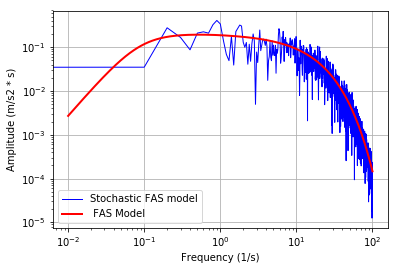

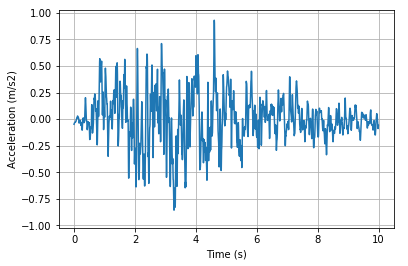

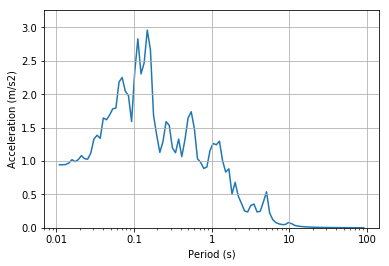

In [11]:
## Get response spectrum with time domain simulation

import matplotlib.pyplot as plt

from synthacc.recordings import Accelerogram
from synthacc.spectral import DFT, FAS, FPS, fft, plot_fass
from synthacc.stochastic import get_windowed_noise


time_delta = 0.005
duration = 10

## Windowed noise

times, windowed_noise = get_windowed_noise(time_delta, duration)

plt.plot(times, windowed_noise)
plt.grid()
plt.show()


## Windowed noise DFT

frequencies, dft_amplitudes = fft(time_delta, windowed_noise)

wn_fas_amplitudes = np.sqrt(
    (dft_amplitudes.real)**2 +
    (dft_amplitudes.imag)**2
    )

wn_fps_amplitudes = np.arctan2(
    dft_amplitudes.imag,
    dft_amplitudes.real,
    )

plt.loglog(frequencies, wn_fas_amplitudes)
plt.grid()
plt.show()


## Windowed noise normalised FAS

n_wn_fas_amplitudes = wn_fas_amplitudes / np.sqrt(np.mean(wn_fas_amplitudes**2))

plt.loglog(frequencies, n_wn_fas_amplitudes)
plt.grid()
plt.show()


## Stochastic FAS

stochastic_fas = FAS(frequencies, np.interp(frequencies, fas3.frequencies, fas3.amplitudes) * n_wn_fas_amplitudes, fas3.unit)

plot_fass([stochastic_fas, fas3], labels=['Stochastic FAS model', ' FAS Model'], colors=['b', 'r'], widths=[1, 2])
plt.show()


## Time domain simulation

fps = FPS(frequencies, wn_fps_amplitudes)
dft = DFT.from_fas_and_fps(stochastic_fas, fps)
acc = Accelerogram.from_seismogram(dft.get_seismogram(time_delta))

acc.plot()


## Response

tds_rs = acc.get_response_spectrum(periods, damping=0.05, gmt='acc')
tds_rs.plot()

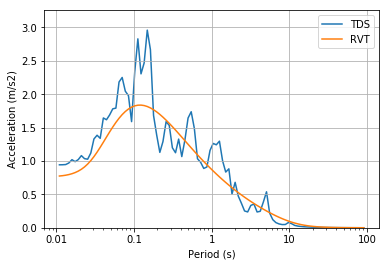

In [12]:
from synthacc.response import plot_response_spectra


plot_response_spectra([tds_rs, rvt_rs], labels=['TDS', 'RVT'])

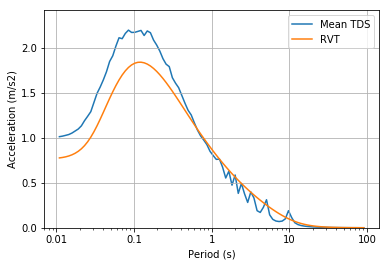

In [13]:
from synthacc.response import ResponseSpectrum


n = 100

response_spectra = np.zeros((n, len(periods)))

for i in range(n):
    times, windowed_noise = get_windowed_noise(time_delta, duration)
    frequencies, dft_amplitudes = fft(time_delta, windowed_noise)
    wn_fas_amplitudes = np.sqrt(
        (dft_amplitudes.real)**2 +
        (dft_amplitudes.imag)**2
        )

    wn_fps_amplitudes = np.arctan2(
        dft_amplitudes.imag,
        dft_amplitudes.real,
        )
    n_wn_fas_amplitudes = wn_fas_amplitudes / np.sqrt(np.mean(wn_fas_amplitudes**2))
    stochastic_fas = FAS(frequencies, np.interp(frequencies, fas3.frequencies, fas3.amplitudes) * n_wn_fas_amplitudes, fas3.unit)
    fps = FPS(frequencies, wn_fps_amplitudes)
    dft = DFT.from_fas_and_fps(stochastic_fas, fps)
    acc = Accelerogram.from_seismogram(dft.get_seismogram(time_delta))
    tds_rs = acc.get_response_spectrum(periods, damping=0.05, gmt='acc')
    response_spectra[i] = tds_rs.responses
    
mean_rs = ResponseSpectrum(periods, np.mean(response_spectra, axis=0), unit='m/s2', damping=0.05)

plot_response_spectra([mean_rs, rvt_rs], labels=['Mean TDS', 'RVT'])